<a href="https://colab.research.google.com/github/amrahmani/Marketing/blob/main/AIMarketing_Ch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLV calculation**

1. Explore the dataset and summarize its features.

In [1]:
import pandas as pd

# First Steps: Load the dataset
url = 'https://raw.githubusercontent.com/amrahmani/Marketing/main/marketing_campaign_data.csv'
df = pd.read_csv(url)

# View the structure of the dataset
print("First 5 rows of the dataset:")
print(df.head())
print("\n")

# Identify key columns
print("Key columns identified: ID, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response")
print("\n")

# Data Cleaning: Remove missing values and duplicates
print(f"Number of rows before removing missing values: {len(df)}")
df_cleaned = df.dropna()
print(f"Number of rows after removing missing values: {len(df_cleaned)}")

print(f"Number of rows before removing duplicates: {len(df_cleaned)}")
df_cleaned = df_cleaned.drop_duplicates()
print(f"Number of rows after removing duplicates: {len(df_cleaned)}")
print("\n")

# Summary Statistics: Compute descriptive statistics
print("Summary statistics of the cleaned dataset:")
print(df_cleaned.describe())
print("\n")

# Compute CLV
# Formula: CLV = Average Purchase Value × Purchase Frequency × Customer Lifespan

# Calculate Total Spending per Customer
mnt_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_cleaned['Total_Spending'] = df_cleaned[mnt_cols].sum(axis=1)

# Calculate Total Purchases per Customer
num_purchases_cols = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df_cleaned['Total_Purchases'] = df_cleaned[num_purchases_cols].sum(axis=1)

# Calculate Average Purchase Value
df_cleaned['Avg_Purchase_Value'] = df_cleaned['Total_Spending'] / df_cleaned['Total_Purchases']
df_cleaned['Avg_Purchase_Value'] = df_cleaned['Avg_Purchase_Value'].replace([float('inf'), float('nan')], 0)

# Calculate Purchase Frequency (assuming 1 year lifespan for simplicity based on available data)
# We don't have explicit purchase dates for each transaction,
# so we'll use the total number of purchases as a proxy for frequency within the observed period.
df_cleaned['Purchase_Frequency'] = df_cleaned['Total_Purchases']

# Estimate Customer Lifespan (in years).
# We have the 'Dt_Customer' which indicates when the customer enrolled.
# Without a clear end date or churn information, we'll make a simplified assumption.
# Let's assume the observation period is roughly 2 years based on the latest enrollment date.
# We can calculate the time difference between the latest and earliest enrollment date as a proxy.
df_cleaned['Dt_Customer'] = pd.to_datetime(df_cleaned['Dt_Customer'])
latest_date = df_cleaned['Dt_Customer'].max()
earliest_date = df_cleaned['Dt_Customer'].min()
lifespan_months = (latest_date - earliest_date).days / 30.44  # Average days in a month
estimated_lifespan_years = lifespan_months / 12
df_cleaned['Customer_Lifespan'] = estimated_lifespan_years

# Calculate CLV
df_cleaned['CLV'] = df_cleaned['Avg_Purchase_Value'] * df_cleaned['Purchase_Frequency'] * df_cleaned['Customer_Lifespan']

# Output: Add a CLV column to the DataFrame
print("\nDataFrame with CLV column:")
print(df_cleaned[['ID', 'Income', 'Total_Spending', 'Total_Purchases', 'Avg_Purchase_Value', 'Purchase_Frequency', 'Customer_Lifespan', 'CLV']].head())
print("\n")

# Verify results with summary statistics of CLV
print("Summary statistics of the CLV column:")
print(df_cleaned['CLV'].describe())

# **Identify 10 High-Value Customers:**
# Sort the DataFrame by CLV in descending order and select the top 10
top_10_high_value_customers = df_cleaned.sort_values(by='CLV', ascending=False).head(10)

print("Top 10 High-Value Customers (based on CLV):")
print(top_10_high_value_customers[['ID', 'CLV']])

First 5 rows of the dataset:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  6182        1984  Graduation       Together  26646.0        1         0   
3  7446        1967      Master       Together  62513.0        0         1   
4  6177        1985         PhD        Married  33454.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  2012-09-04       58       635  ...                  7             0   
1  2014-03-08       38        11  ...                  5             0   
2  2014-02-10       26        11  ...                  6             0   
3  2013-09-09       16       520  ...                  6             0   
4  2013-05-08       32        76  ...                  8             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2

2. Create a histogram to show the distribution of CLV values. This highlights high-value customers.

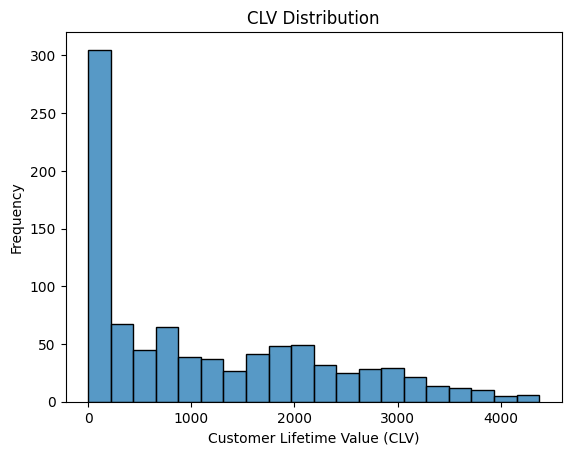


Histogram of CLV distribution has been saved as 'clv_histogram.png'.

Interpretation: A right-skewed histogram indicates most customers have low CLV. Outliers on the right represent high-value targets.


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# **Create a histogram to show the distribution of CLV values**
sns.histplot(df_cleaned['CLV'], bins=20)
plt.title('CLV Distribution')
plt.xlabel('Customer Lifetime Value (CLV)')
plt.ylabel('Frequency')
plt.savefig('clv_histogram.png')
plt.show()

print("\nHistogram of CLV distribution has been saved as 'clv_histogram.png'.")
print("\nInterpretation: A right-skewed histogram indicates most customers have low CLV. Outliers on the right represent high-value targets.")

# **Customer Segmentation**

3. Prepare the dataset for K-means. Scale features and check for outliers.

In [4]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Assuming 'df_cleaned' DataFrame from the previous steps is available

print("\n--- Customer Segmentation Preparation ---")

# Step 1: Feature Selection
segmentation_features = ['CLV', 'Income', 'Purchase_Frequency']
df_segmentation = df_cleaned[segmentation_features].copy()
print("\nSelected features for segmentation:")
print(df_segmentation.head())

# Step 2: Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_segmentation)
df_scaled = pd.DataFrame(scaled_features, columns=segmentation_features, index=df_segmentation.index)
print("\nScaled features:")
print(df_scaled.head())

# Step 3: Outlier Removal using Z-scores
z = stats.zscore(df_scaled)
abs_z = abs(z)
filtered_entries = (abs_z < 3).all(axis=1) # Keep rows with all z-scores less than 3
df_no_outliers = df_scaled[filtered_entries]
print(f"\nNumber of data points before outlier removal: {len(df_scaled)}")
print(f"Number of data points after outlier removal (Z-score < 3): {len(df_no_outliers)}")
print("\nDataframe after outlier removal:")
print(df_no_outliers.head())

# Step 4: Data Quality Check (already performed in previous steps with dropna() and drop_duplicates())
print("\nData quality check: Missing values and duplicates were handled in the previous steps.")
print(f"Number of rows in the final dataset for clustering: {len(df_no_outliers)}")
print("\nPrepared dataset for K-means clustering (scaled and outliers removed).")


--- Customer Segmentation Preparation ---

Selected features for segmentation:
           CLV   Income  Purchase_Frequency
0  3010.183968  58138.0                  25
1    50.262812  46344.0                   6
2    98.664039  26646.0                   8
3  1332.895313  62513.0                  22
4   314.607972  33454.0                  10

Scaled features:
        CLV    Income  Purchase_Frequency
0  1.651288  0.155793            1.298480
1 -0.982543 -0.234608           -1.172455
2 -0.939474 -0.886644           -0.912356
3  0.158784  0.300612            0.908333
4 -0.747320 -0.661288           -0.652258

Number of data points before outlier removal: 905
Number of data points after outlier removal (Z-score < 3): 898

Dataframe after outlier removal:
        CLV    Income  Purchase_Frequency
0  1.651288  0.155793            1.298480
1 -0.982543 -0.234608           -1.172455
2 -0.939474 -0.886644           -0.912356
3  0.158784  0.300612            0.908333
4 -0.747320 -0.661288       

4. Train a K-means model and save cluster labels. Visualize the results.


--- K-Means Clustering ---


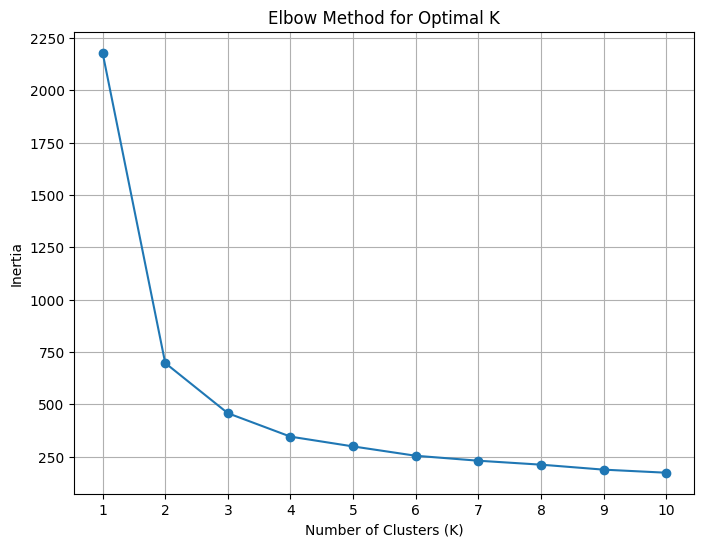


Observe the Elbow Method plot to identify the optimal number of clusters (K). The 'elbow' point is where the rate of decrease in inertia starts to slow down.

Cluster labels added to the DataFrame without outliers (df_no_outliers):
        CLV    Income  Purchase_Frequency  Cluster
0  1.651288  0.155793            1.298480        1
1 -0.982543 -0.234608           -1.172455        0
2 -0.939474 -0.886644           -0.912356        0
3  0.158784  0.300612            0.908333        2
4 -0.747320 -0.661288           -0.652258        0

Original cleaned DataFrame (df_cleaned) with cluster labels (NaN for removed outliers):
     ID          CLV   Income  Purchase_Frequency  Cluster
0  5524  3010.183968  58138.0                  25      1.0
1  2174    50.262812  46344.0                   6      0.0
2  6182    98.664039  26646.0                   8      0.0
3  7446  1332.895313  62513.0                  22      2.0
4  6177   314.607972  33454.0                  10      0.0


<ipython-input-5-54df79d0b837>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Cluster'] = kmeans.labels_


In [5]:
from sklearn.cluster import KMeans

# Assuming 'df_no_outliers' DataFrame from the previous step is available

print("\n--- K-Means Clustering ---")

# Step 1: Choosing the number of clusters (K) using the Elbow Method
inertia = []
k_range = range(1, 11)  # Try K from 1 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(df_no_outliers)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

print("\nObserve the Elbow Method plot to identify the optimal number of clusters (K). The 'elbow' point is where the rate of decrease in inertia starts to slow down.")

# Step 2: Applying K-Means with the chosen K (let's assume K=3 based on a potential elbow)
n_clusters = 3  # Replace with the K you identified from the elbow method
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(df_no_outliers)

# Step 3: Adding cluster labels to the DataFrame used for training (df_no_outliers)
df_no_outliers['Cluster'] = kmeans.labels_
print("\nCluster labels added to the DataFrame without outliers (df_no_outliers):")
print(df_no_outliers.head())

# If you need the cluster labels in the original df_cleaned, you can merge based on the index
df_cleaned_merged = df_cleaned.merge(df_no_outliers['Cluster'], left_index=True, right_index=True, how='left')
print("\nOriginal cleaned DataFrame (df_cleaned) with cluster labels (NaN for removed outliers):")
print(df_cleaned_merged[['ID', 'CLV', 'Income', 'Purchase_Frequency', 'Cluster']].head())

5. Create a scatter plot of clusters. Write your interpretation.


--- Customer Segment Visualization ---


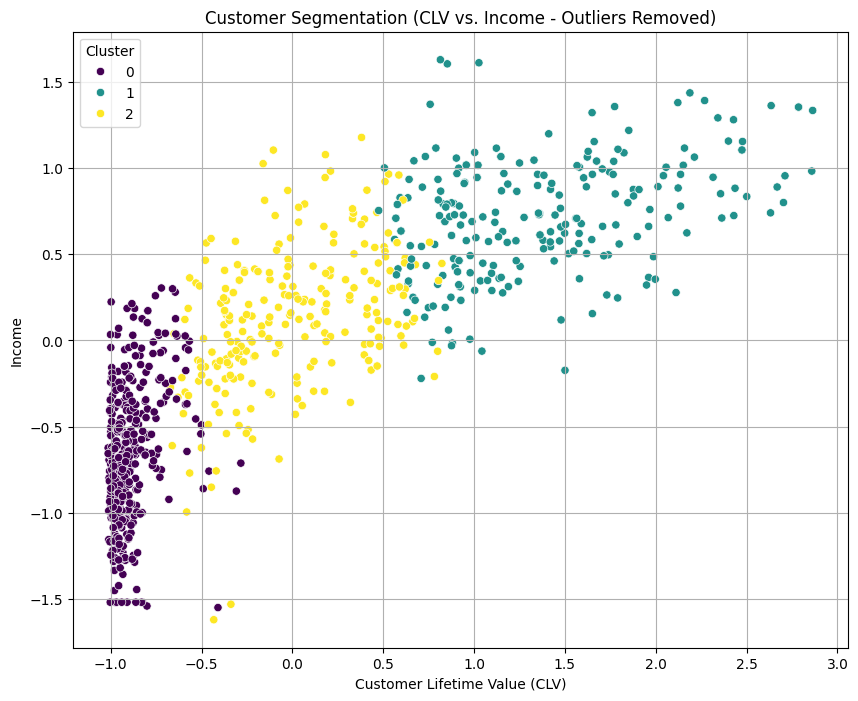


Scatter plot of CLV vs. Income colored by cluster (K=3) for data without outliers is displayed.
This visualization shows the segments formed after outlier removal.

Scatter plot of customer segments (based on CLV and Income) has been saved as 'clusters.png'.

Interpretation:
- Distinct clusters that are well-separated visually suggest that the K-means algorithm has effectively identified distinct groups of customers based on their CLV and income.
- Overlapping clusters might indicate that the boundaries between segments are not very clear based on these two features alone. In such cases, incorporating more features (e.g., purchase frequency, recency, demographics) into the clustering process might help to create more well-defined and interpretable segments.
- The size and density of each cluster can also provide insights into the prevalence of different customer types within your customer base.
- By examining the location of each cluster on the plot, you can understand the characteris

In [6]:
# Assuming 'df_cleaned_merged' (or 'df_no_outliers' with 'Cluster' column) is available

print("\n--- Customer Segment Visualization ---")

# Visualization of Clusters (CLV vs. Income) using df_no_outliers
plt.figure(figsize=(10, 8))
sns.scatterplot(x='CLV', y='Income', hue='Cluster', data=df_no_outliers, palette='viridis')
plt.title('Customer Segmentation (CLV vs. Income - Outliers Removed)')
plt.xlabel('Customer Lifetime Value (CLV)')
plt.ylabel('Income')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

print(f"\nScatter plot of CLV vs. Income colored by cluster (K={n_clusters}) for data without outliers is displayed.")
print("This visualization shows the segments formed after outlier removal.")

print("\nScatter plot of customer segments (based on CLV and Income) has been saved as 'clusters.png'.")
print("\nInterpretation:")
print("- Distinct clusters that are well-separated visually suggest that the K-means algorithm has effectively identified distinct groups of customers based on their CLV and income.")
print("- Overlapping clusters might indicate that the boundaries between segments are not very clear based on these two features alone. In such cases, incorporating more features (e.g., purchase frequency, recency, demographics) into the clustering process might help to create more well-defined and interpretable segments.")
print("- The size and density of each cluster can also provide insights into the prevalence of different customer types within your customer base.")
print("- By examining the location of each cluster on the plot, you can understand the characteristics of each segment in terms of their CLV and income levels (e.g., high-CLV, high-income segment in the top right).")

6. Interpret the results of the customer segmentation

In [ ]:
# Assuming 'df_cleaned_merged' (or 'df_no_outliers' with 'Cluster' column) is available

print("\n--- Customer Segment Analysis and Marketing Applications ---")

# Determine which DataFrame to use for analysis
if 'df_cleaned_merged' in locals():
    df_segment_analysis = df_cleaned_merged.copy()
else:
    df_segment_analysis = df_no_outliers.copy()
    # Merge back demographic data for richer analysis if needed
    df_segment_analysis = df_segment_analysis.merge(df[['Education', 'Marital_Status', 'Kidhome', 'Teenhome']],
                                                    left_index=True, right_index=True, how='left')

# Compute average CLV, income, and purchase frequency per cluster
cluster_profiles = df_segment_analysis.groupby('Cluster')[['CLV', 'Income', 'Purchase_Frequency']].mean().reset_index()
print("\nAverage CLV, Income, and Purchase Frequency per Cluster:")
print(cluster_profiles)

# Analyze additional features per cluster (if available after merging)
if 'Education' in df_segment_analysis.columns:
    print("\nMost Common Education Level per Cluster:")
    print(df_segment_analysis.groupby('Cluster')['Education'].agg(lambda x: x.mode()[0]))

if 'Marital_Status' in df_segment_analysis.columns:
    print("\nMost Common Marital Status per Cluster:")
    print(df_segment_analysis.groupby('Cluster')['Marital_Status'].agg(lambda x: x.mode()[0]))

if 'Kidhome' in df_segment_analysis.columns:
    print("\nAverage Number of Kids at Home per Cluster:")
    print(df_segment_analysis.groupby('Cluster')['Kidhome'].mean())

if 'Teenhome' in df_segment_analysis.columns:
    print("\nAverage Number of Teens at Home per Cluster:")
    print(df_segment_analysis.groupby('Cluster')['Teenhome'].mean())

print("\n--- Marketing Applications and Strategies ---")

# Identify High-Value Segment(s)
high_value_clusters = cluster_profiles[cluster_profiles['CLV'] > cluster_profiles['CLV'].mean()]['Cluster'].tolist()
if high_value_clusters:
    print(f"\nHigh-Value Segment(s) (Cluster(s) {high_value_clusters}):")
    print("- Focus on retention and loyalty programs (e.g., exclusive offers, early access, premium support).")
    print("- Encourage higher spending through upselling and cross-selling of premium products/services.")
    print("- Seek feedback and build strong relationships to foster brand advocacy.")

# Identify Low-Value Segment(s)
low_value_clusters = cluster_profiles[cluster_profiles['CLV'] <= cluster_profiles['CLV'].mean()]['Cluster'].tolist()
if low_value_clusters:
    print(f"\nLow-Value Segment(s) (Cluster(s) {low_value_clusters}):")
    print("- Explore strategies to increase engagement and purchase frequency (e.g., targeted discounts, bundled offers, content marketing).")
    print("- Analyze reasons for low value (e.g., new customers, different needs) to tailor approaches.")
    print("- Consider cost-effective marketing channels for this segment.")

# General Marketing Applications
print("\nGeneral Marketing Applications:")
print("- Personalize marketing messages and offers based on the characteristics of each segment (e.g., demographics, purchase behavior).")
print("- Tailor product recommendations and content to align with segment preferences.")
print("- Optimize marketing spend by focusing resources on the most valuable segments.")
print("- Monitor segment performance and adapt strategies as needed.")


--- Customer Segment Analysis and Marketing Applications ---

Average CLV, Income, and Purchase Frequency per Cluster:
   Cluster          CLV        Income  Purchase_Frequency
0      0.0   157.526988  33827.471354            7.429688
1      1.0  1307.893584  59159.544892           20.687307
2      2.0  2890.077582  77466.047120           20.502618

Most Common Education Level per Cluster:
Cluster
0.0    Graduation
1.0    Graduation
2.0    Graduation
Name: Education, dtype: object

Most Common Marital Status per Cluster:
Cluster
0.0    Married
1.0    Married
2.0    Married
Name: Marital_Status, dtype: object

Average Number of Kids at Home per Cluster:
Cluster
0.0    0.794271
1.0    0.275542
2.0    0.052356
Name: Kidhome, dtype: float64

Average Number of Teens at Home per Cluster:
Cluster
0.0    0.460938
1.0    0.749226
2.0    0.214660
Name: Teenhome, dtype: float64

--- Marketing Applications and Strategies ---

High-Value Segment(s) (Cluster(s) [2.0]):
- Focus on retention and loya

**Activity:**

**Task 1:** In step 3, select various features, including categorical data, and then apply K-means clustering for customer segmentation.

**Task2:** Calculate CLV and segment customers using the Kaggle dataset. This supports direct and database marketing strategies.

**Tasks:** Load the dataset, compute CLV, visualize CLV distribution, and apply K-means clustering. Propose a marketing campaign based on segments.

**Tools:** Use Python with pandas, matplotlib, seaborn, and scikit-learn. Google Collab will organize your work.

